## Visualizing trends
====================

Texts often have a sequence. Newspapers and periodicals have volumes.
Novels have chapters. Personal diaries have dated entries. Visualizations of
topic models may benefit from incorporating information about where a text falls
in a sequence.

As a motivating example, consider Victor Hugo's *Les MisÃ©rables*. Over 500,000
words long, the book counts as a lengthy text by any
standard.[#fn_les_mis]_ The novel comes in five volumes ("Fantine", "Cosette",
"Marius", "The Idyll in the Rue Plumet and the Epic in the Rue St. Denis", and
"Jean Valjean"). And within each volume we have a sequence of chapters. (And
within each chapter we have a sequence of paragraphs, ...). In this section we
will address how to visualize topic shares in sequence.

To whet your appetite, consider the rise and fall of a topic associated with
revolutionary activity in *Les MisÃ©rables*:

.. figure:: _static/plot_topics_over_time_series_les_miserables.png
    :scale: 60 %
    :alt: Les MisÃ©rables, Topic #35 ("barricade enjolras ...")

(`Enjolras <https://en.wikipedia.org/wiki/Enjolras>`_ is the leader of the
revolutionary *Les Amis de l'ABC*.)

#### Note 
Probabilistic models such as topic models often benefit from
    incorporating information about where an individual text falls in a larger
    sequence of texts :cite:`blei_dynamic_2006`.


In [11]:
import numpy as np; np.set_printoptions(precision=3)
import pandas as pd
import matplotlib.pyplot as plt

### Plotting trends
===============

As always, we first need to fit a topic model to the corpus. As MALLET has no
built-in French stopword list we need to provide one. We will use the `French
stopword list
<http://svn.tartarus.org/snowball/trunk/website/algorithms/french/stop.txt>`_
from the Snowball stemmer package. Additionally, because we are dealing with
non-English text we need to use an alternate regular expression for
tokenization. MALLET helpfully suggests ``--token-regex '[\p{L}\p{M}]+'``.

bash

    mallet-2.0.7/bin/mallet import-dir --input data/hugo-les-misÃ©rables-split/ --output /tmp/topic-input-hugo.mallet --keep-sequence --remove-stopwords --stoplist-file data/stopwords/french.txt --token-regex '[\p{L}\p{M}]+'
    mallet-2.0.7/bin/mallet train-topics --input /tmp/topic-input-hugo.mallet --num-topics 50 --output-doc-topics /tmp/doc-topics-hugo.txt --output-topic-keys /tmp/topic-keys-hugo.txt --word-topic-counts-file /tmp/word-topic-hugo.txt



In [4]:
import os
import shutil
import subprocess

N_TOPICS = 50
MALLET_INPUT = 'source/cache_original/cache/topic-input-hugo-les-miserables-split.mallet'
MALLET_TOPICS = 'source/cache_original/cache/doc-topic-hugo-les-miserables-{}topics.txt'.format(N_TOPICS)
MALLET_WORD_TOPIC_COUNTS = 'source/cache_original/cache/doc-topic-hugo-les-miserables-{}topics-word-topic.txt'.format(N_TOPICS)
MALLET_KEYS = 'source/cache_original/cache/doc-topic-hugo-les-miserables-{}topics-keys.txt'.format(N_TOPICS)

'''
$acnote: did manually
see bash_mallet.txt file
edited --token-regex per suggestion above

if not os.path.exists(MALLET_INPUT):
    subprocess.check_call("""C:/mallet/bin/mallet import-dir --input data/hugo-les-miserables-split/ --output {} --keep-sequence --remove-stopwords --stoplist-file data/stopwords/french.txt --token-regex '[\p{{L}}\p{{M}}]+'""".format(MALLET_INPUT), shell=True)
'''


In [6]:
shutil.copy(MALLET_INPUT,'tmp/topic-input-hugo.mallet')
"""
if not os.path.exists(MALLET_TOPICS):
    subprocess.check_call('mallet-2.0.7/bin/mallet train-topics --input /tmp/topic-input-hugo.mallet --num-iterations 5000 --num-topics {} --output-doc-topics {} --output-topic-keys {} --word-topic-counts-file {} --random-seed 1'.format(N_TOPICS, MALLET_TOPICS, MALLET_KEYS, MALLET_WORD_TOPIC_COUNTS), shell=True)
"""
shutil.copy(MALLET_TOPICS,'tmp/doc-topics-hugo.txt')
shutil.copy(MALLET_KEYS,'tmp/topic-keys-hugo.txt')
shutil.copy(MALLET_WORD_TOPIC_COUNTS,'tmp/word-topic-hugo.txt')


'tmp/word-topic-hugo.txt'

As usual, we post-process the MALLET output in order to get a matrix of topic
proportions. Each row of the matrix holds the topic proportions associated with
a document.

In [7]:
import numpy as np
import itertools
import operator
import os

def grouper(n, iterable, fillvalue=None):
    "Collect data into fixed-length chunks or blocks"
    # grouper(3, 'ABCDEFG', 'x') --> ABC DEF Gxx"
    args = [iter(iterable)] * n
    return itertools.zip_longest(*args, fillvalue=fillvalue)

doctopic_triples = []
with open("tmp/doc-topics-hugo.txt") as f:
    f.readline()  # read one line in order to skip the header
    for line in f:
        docnum, docname, *values = line.rstrip().split('\t')
        for topic, share in grouper(2, values):
            triple = (docname, int(topic), float(share))
            doctopic_triples.append(triple)

# sort the triples
doctopic_triples.sort(key=operator.itemgetter(0,1))
docnames = sorted(set([triple[0] for triple in doctopic_triples]))
docnames_base = np.array([os.path.splitext(os.path.basename(n))[0] for n in docnames])
num_topics = len(doctopic_triples) // len(docnames)

doctopic = np.empty((len(docnames), num_topics))
for i, (doc_name, triples) in enumerate(itertools.groupby(doctopic_triples, key=operator.itemgetter(0))):
    doctopic[i, :] = np.array([share for _, _, share in triples])

docnames = docnames_base

# get the topic words
with open('tmp/topic-keys-hugo.txt') as input:
    topic_keys_lines = input.readlines()
topic_words = []
for line in topic_keys_lines:
    _, _, words = line.split('\t')  # tab-separated
    words = words.rstrip().split(' ')  # remove the trailing '\n'
    topic_words.append(words)


Among the fifty topics there is one topic (#35 using 0-based indexing) that
jumps out as characteristic of events towards the close of the novel. The words
most strongly connected with this topic include "barricade", "fusil", and
"cartouches" ("barricade", "rifle", and "cartridges").


In [9]:
','.join(topic_words[35])

'barricade,enjolras,rue,coups,coup,pavÃ©s,fusil,feu,cabaret,deux,dit,mort,drapeau,combeferre,chef,insurgÃ©s,quelques,armes,canon'

Because the documents are ordered in a sequence, we can plot the fate, so to
speak, of this topic over time with the following lines of code:

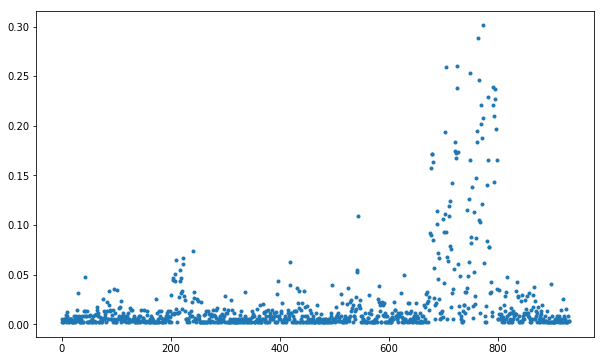

In [16]:
series = doctopic[:, 35]

plt.figure(figsize=(10,6))
plt.plot(series, '.')  # '.' specifies the type of mark to use on the graph
plt.savefig('plots/plot_7Vis_topics_over_time_series_simple.png', bbox_inches='tight')
plt.show()

While this visualization communicates the essential information about the
prevalence of a topic in the corpus, it is not perfect. We can improve it. It
would, for instance, be useful to include an indication of where the various
volumes start and end. Another enhancement would add some kind of "smoothing" to
the time series in order to better communicate the underlying trend.

A rolling average of the topic shares turns out be a useful form of smoothing in
this case. We are interested in the prevalence of a topic over time and whether
a topic disappears completely in one 500-word chunk of text (only to reappear in
the next) does not interest us. We want to visualize the underlying trend, that
is, we need some model or heuristic capable of capturing the idea
that the topic (or any similar feature) has an underlying propensity to appear at
varying points of the novel and that while this propensity may change over time it
does not fluctuate wildly. [#fn_lowess]_

Recall that a rolling or moving average of a time series associates with each
point in the series the average of some fixed number of previous
observations (including the current observation). This fixed number of
observations is often
called a "window". The idea of a rolling mean (conveniently implemented in
``pandas.rolling_mean()``) is effectively communicated visually:

In [14]:
z = np.array([  3.,   2.,   3.,   6.,   2.,   3.,   1.,   3.,   8.,   3.,   5.,
                   8.,   7.,   8.,   7.,   6.,   8.,   7.,   7.,   5.,   8.,   6.,
                  11.,   6.,   7.,   8.,   8.,   6.,   9.,  15.,  13.,  10.,   9.])
pd.rolling_mean(z, 3)


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  after removing the cwd from sys.path.


array([    nan,     nan,   2.667,   3.667,   3.667,   3.667,   2.   ,
         2.333,   4.   ,   4.667,   5.333,   5.333,   6.667,   7.667,
         7.333,   7.   ,   7.   ,   7.   ,   7.333,   6.333,   6.667,
         6.333,   8.333,   7.667,   8.   ,   7.   ,   7.667,   7.333,
         7.667,  10.   ,  12.333,  12.667,  10.667])

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


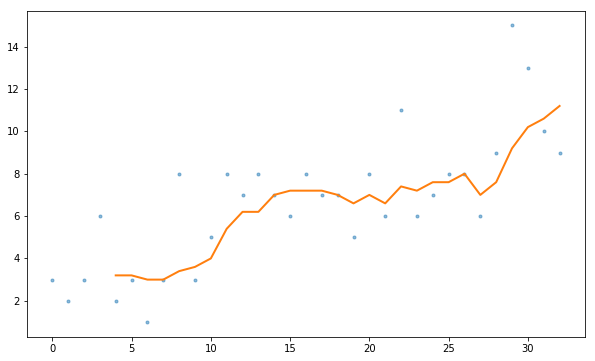

In [17]:
plt.figure(figsize=(10,6))
plt.plot(z, '.', alpha=0.5)
plt.plot(pd.rolling_mean(z, 5), '-', linewidth=2)
plt.savefig('plots/plot_7Vis_topics_over_time_rolling_mean.png', bbox_inches='tight')
plt.show()

After making these two improvements---marking the volume boundaries and adding
a trend line based on a rolling average---the time series for our topic does
a better job of orienting us in the novel and communicating the points in the
novel where the topic appears:


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  """


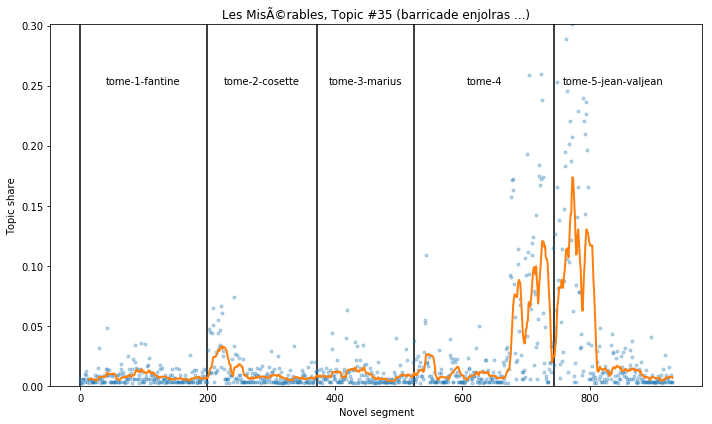

In [19]:
# the values on the x-axis (xs) are simply a sequence of integers
# corresponding to the texts (also the rows in the document topic matrix)
xs = np.arange(len(series))

series_smooth = pd.rolling_mean(series, 15)  # 15 seems to work well here

# now we need to calculate at what index each volume starts
# there are many ways to do this, two methods are shown below
# method #1
volume_names = ["tome-1-fantine", "tome-2-cosette", "tome-3-marius", "tome-4", "tome-5-jean-valjean"]
volume_indexes = []
for volname in volume_names:
    for i, docname in enumerate(docnames):
        if volname in docname:
            volume_indexes.append(i)
            break

#volume_indexes_prev = volume_indexes

# method #2, use NumPy functions
volume_indexes = []
for volname in volume_names:
    volume_indexes.append(np.min(np.nonzero([volname in docname for docname in docnames])))

#print( volume_indexes == volume_indexes_prev)

# now we can assemble the plot
plt.figure(figsize=(10,6))
plt.plot(series, '.', alpha=0.3)
plt.plot(series_smooth, '-', linewidth=2)
plt.vlines(volume_indexes, ymin=0, ymax=np.max(series))
text_xs = np.array(volume_indexes) + np.diff(np.array(volume_indexes + [max(xs)]))/2
text_ys = np.repeat(max(series), len(volume_names)) - 0.05
for x, y, s in zip(text_xs, text_ys, volume_names):
    plt.text(x, y, s, horizontalalignment='center')

plt.title('Les MisÃ©rables, Topic #35 (barricade enjolras ...)')
plt.ylabel("Topic share")
plt.xlabel("Novel segment")
plt.ylim(0, max(series))

plt.savefig('plots/plot_7Vis_topics_over_time_series_les_miserables.png', bbox_inches='tight')
plt.tight_layout()
plt.show()



There are of many other topics that appear in our fit of the corpus. Looping
over the topics and saving an image for each topic is straightforward:

In [23]:
for i in range(num_topics):
    plt.clf()  # clears the current plot
    series = doctopic[:, i]
    xs = np.arange(len(series))
    series_smooth = pd.rolling_mean(series, 15)
    plt.plot(series, '.')
    plt.plot(series_smooth, '-', linewidth=2)
    plt.title("Topic {}: {}".format(i, ','.join(topic_words[i])))
    savefig_fn = "plots/plot_7Vis_topics_les_miserables/hugo-topic{}.pdf".format(i)
    plt.savefig(savefig_fn, format='pdf')


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  """


#### FOOTNOTES

[#fn_les_mis] The text of Les MisÃ©rables has been used in a variety of
    (interactive) visualization projects, including `Les MisÃ©rables
    Co-occurrence <http://bost.ocks.org/mike/miserables/>`_ and `Novel Views:
    Les Miserables <http://neoformix.com/2013/NovelViews.html>`_.

[#fn_lowess] For generic smoothing those accustomed to using R will be
    familiar with the function ``loess()`` which implements the most common form
    of scatterplot smoothing. In Python a similar function
    (``statsmodels.nonparametric.lowess()``) is available in the ``statsmodels``
    package. While we might be tempted to use such a function to communicate
    visually the basic trend, we will be better served if we think of the
    sequence of topic shares as a proper time series rather than (merely)
    a sequence of dependant and independent variables suitable for visualization
    in a scatter plot.
